# YOLOv8 Object Detection Training

This notebook trains/fine-tunes YOLOv8 on the UML class diagram dataset to detect:
- **arrow** (class 0) - Relationship arrows between classes
- **class** (class 1) - UML class boxes
- **cross** (class 2) - Cross markers

**Approach**: Fine-tune a pretrained YOLOv8m model on our custom dataset.

**Contents**:
1. Setup and GPU verification
2. Load and verify dataset
3. Configure training parameters
4. Train the model
5. Evaluate performance
6. Run inference on test images
7. Save and export model

## 1. Setup and Imports

In [3]:
import os
import sys
from pathlib import Path
import yaml
import shutil

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from ultralytics import YOLO
import kagglehub

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 3090
GPU Memory: 25.77 GB


In [8]:
# Set device
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'
print(f"Using device: {DEVICE}")
if DEVICE == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Project paths
PROJECT_ROOT = Path.cwd().parent
RUNS_DIR = PROJECT_ROOT / 'runs' / 'detect'
MODELS_DIR = PROJECT_ROOT / 'models'

# Create directories if they don't exist
RUNS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Runs directory: {RUNS_DIR}")
print(f"Models directory: {MODELS_DIR}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
GPU Memory: 25.77 GB
Project root: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool
Runs directory: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool\runs\detect
Models directory: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool\models


## 2. Load and Verify Dataset

In [9]:
# Download/access dataset
dataset_path = kagglehub.dataset_download(
    "domenicoarm/uml-class-diagram-dataset-bounded-box-rating"
)
dataset_dir = Path(dataset_path)
print(f"Dataset path: {dataset_dir}")

# Path to YOLO dataset
yolo_dir = dataset_dir / "UML_YOLOv8"
data_yaml_path = yolo_dir / "data.yaml"

print(f"\nYOLO dataset directory: {yolo_dir}")
print(f"data.yaml exists: {data_yaml_path.exists()}")

Dataset path: C:\Users\Aiden Smith\.cache\kagglehub\datasets\domenicoarm\uml-class-diagram-dataset-bounded-box-rating\versions\2

YOLO dataset directory: C:\Users\Aiden Smith\.cache\kagglehub\datasets\domenicoarm\uml-class-diagram-dataset-bounded-box-rating\versions\2\UML_YOLOv8
data.yaml exists: True


In [10]:
# Load and display data.yaml configuration
with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("Dataset Configuration:")
print(f"  Number of classes: {data_config['nc']}")
print(f"  Class names: {data_config['names']}")
print(f"  Train path: {data_config.get('train', 'N/A')}")
print(f"  Val path: {data_config.get('val', 'N/A')}")
print(f"  Test path: {data_config.get('test', 'N/A')}")

Dataset Configuration:
  Number of classes: 3
  Class names: ['arrow', 'class', 'cross']
  Train path: ../train/images
  Val path: ../valid/images
  Test path: ../test/images


In [11]:
# Count images in each split
splits = ['train', 'valid', 'test']
split_counts = {}

for split in splits:
    images_dir = yolo_dir / split / 'images'
    labels_dir = yolo_dir / split / 'labels'
    
    if images_dir.exists():
        image_count = len(list(images_dir.glob('*.jpg'))) + len(list(images_dir.glob('*.jpeg')))
        label_count = len(list(labels_dir.glob('*.txt')))
        split_counts[split] = {'images': image_count, 'labels': label_count}
        print(f"{split.capitalize():6s}: {image_count} images, {label_count} labels")

total_images = sum(s['images'] for s in split_counts.values())
print(f"\nTotal: {total_images} images")

Train : 497 images, 497 labels
Valid : 61 images, 61 labels
Test  : 63 images, 63 labels

Total: 621 images


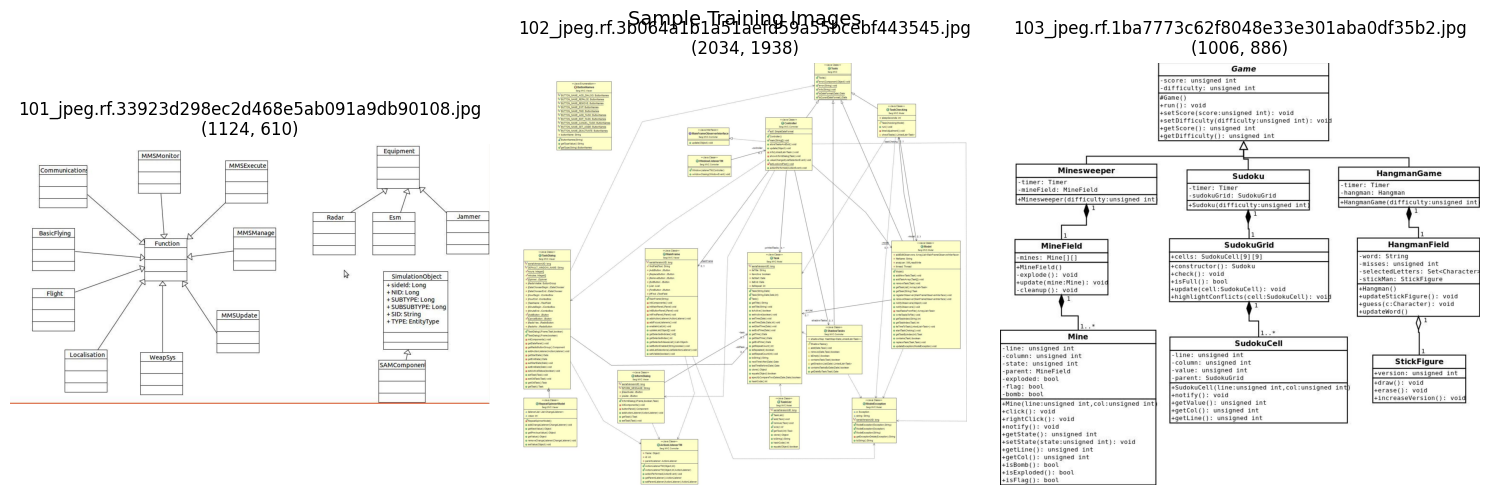

In [12]:
# Display sample image from training set
train_images_dir = yolo_dir / 'train' / 'images'
sample_images = list(train_images_dir.glob('*.jpg'))[:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    axes[idx].imshow(np.array(img))
    axes[idx].set_title(f"{img_path.name}\n{img.size}")
    axes[idx].axis('off')

plt.suptitle("Sample Training Images", fontsize=14)
plt.tight_layout()
plt.show()

## 3. Model Selection

YOLOv8 model sizes:
- **nano (n)**: 3.2M params - Fastest, lowest accuracy
- **small (s)**: 11.2M params - Fast, decent accuracy
- **medium (m)**: 25.9M params - Balanced ← **Good default for CUDA GPUs**
- **large (l)**: 43.7M params - Slower, high accuracy
- **xlarge (x)**: 71.4M params - Slowest, highest accuracy

With 24GB VRAM (RTX 3090), we can comfortably use YOLOv8m with batch size 32.

In [13]:
# Load pretrained YOLOv8 model
# Options: 'n' (nano), 's' (small), 'm' (medium), 'l' (large), 'x' (xlarge)
MODEL_SIZE = 'm'
model = YOLO(f'yolov8{MODEL_SIZE}.pt')

print(f"Loaded YOLOv8{MODEL_SIZE} model")
print(f"Model type: {model.task}")

Loaded YOLOv8m model
Model type: detect


## 4. Training Configuration

Key parameters for fine-tuning:
- **epochs**: 100 (with early stopping)
- **batch**: 32 (RTX 3090 24GB can handle this easily)
- **imgsz**: 640 (standard YOLO size)
- **lr0**: 0.001 (lower than default for fine-tuning)
- **patience**: 20 (early stopping if no improvement)

In [14]:
# Training configuration
TRAINING_CONFIG = {
    # Dataset
    'data': str(data_yaml_path),
    
    # Training parameters
    'epochs': 20,
    'imgsz': 640,
    'batch': 32,
    
    # Learning rate
    'lr0': 0.001,  # Initial learning rate (lower for fine-tuning)
    'lrf': 0.01,   # Final learning rate (lr0 * lrf)
    
    # Optimizer
    'optimizer': 'SGD',
    'momentum': 0.937,
    'weight_decay': 0.0005,
    
    # Early stopping
    'patience': 20,
    
    # Data augmentation
    'augment': True,
    'mosaic': 1.0,
    'flipud': 0.5,
    'fliplr': 0.5,
    'degrees': 10.0,
    'translate': 0.1,
    'scale': 0.5,
    
    # Hardware
    'device': DEVICE,
    'workers': 8,
    
    # Checkpointing
    'save': True,
    'save_period': 10,
    
    # Output
    'project': str(RUNS_DIR),
    'name': f'uml-yolov8{MODEL_SIZE}',
    'exist_ok': True,
    
    # Visualization
    'plots': True,
    'val': True,
}

print("Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

Training Configuration:
  data: C:\Users\Aiden Smith\.cache\kagglehub\datasets\domenicoarm\uml-class-diagram-dataset-bounded-box-rating\versions\2\UML_YOLOv8\data.yaml
  epochs: 20
  imgsz: 640
  batch: 32
  lr0: 0.001
  lrf: 0.01
  optimizer: SGD
  momentum: 0.937
  weight_decay: 0.0005
  patience: 20
  augment: True
  mosaic: 1.0
  flipud: 0.5
  fliplr: 0.5
  degrees: 10.0
  translate: 0.1
  scale: 0.5
  device: cuda
  workers: 8
  save: True
  save_period: 10
  project: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool\runs\detect
  name: uml-yolov8m
  exist_ok: True
  plots: True
  val: True


## 5. Train the Model

Early stopping will halt training if validation mAP doesn't improve for 20 epochs.

In [15]:
# Start training
print("Starting training...")
print("This may take 30-60 minutes on GPU, longer on CPU.")
print("-" * 50)

results = model.train(**TRAINING_CONFIG)

print("-" * 50)
print("Training complete!")

Starting training...
This may take 30-60 minutes on GPU, longer on CPU.
--------------------------------------------------
Ultralytics 8.4.14  Python-3.12.0 torch-2.10.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Aiden Smith\.cache\kagglehub\datasets\domenicoarm\uml-class-diagram-dataset-bounded-box-rating\versions\2\UML_YOLOv8\data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf

In [16]:
# Display training results summary
print("\n=== Training Results ===")
print(f"Best model saved to: {RUNS_DIR / f'uml-yolov8{MODEL_SIZE}' / 'weights' / 'best.pt'}")

# Load results CSV
results_csv = RUNS_DIR / f'uml-yolov8{MODEL_SIZE}' / 'results.csv'
if results_csv.exists():
    df_results = pd.read_csv(results_csv)
    df_results.columns = df_results.columns.str.strip()  # Clean column names
    print(f"\nTraining completed in {len(df_results)} epochs")
    print(f"\nFinal metrics:")
    last_row = df_results.iloc[-1]
    for col in ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']:
        if col in df_results.columns:
            print(f"  {col}: {last_row[col]:.4f}")


=== Training Results ===
Best model saved to: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool\runs\detect\uml-yolov8m\weights\best.pt

Training completed in 20 epochs

Final metrics:
  metrics/precision(B): 0.8836
  metrics/recall(B): 0.5501
  metrics/mAP50(B): 0.5265
  metrics/mAP50-95(B): 0.3654


## 6. Evaluate Performance

In [17]:
# Load the best model for evaluation
best_model_path = RUNS_DIR / f'uml-yolov8{MODEL_SIZE}' / 'weights' / 'best.pt'
best_model = YOLO(str(best_model_path))
print(f"Loaded best model from: {best_model_path}")

Loaded best model from: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool\runs\detect\uml-yolov8m\weights\best.pt


In [18]:
# Validate on validation set
print("\n=== Validation Set Results ===")
val_results = best_model.val(data=str(data_yaml_path), split='val')

print(f"\nValidation Metrics:")
print(f"  mAP50: {val_results.box.map50:.4f}")
print(f"  mAP50-95: {val_results.box.map:.4f}")
print(f"  Precision: {val_results.box.mp:.4f}")
print(f"  Recall: {val_results.box.mr:.4f}")


=== Validation Set Results ===
Ultralytics 8.4.14  Python-3.12.0 torch-2.10.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
Model summary (fused): 93 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1055.6569.3 MB/s, size: 171.0 KB)
val: Scanning C:\Users\Aiden Smith\.cache\kagglehub\datasets\domenicoarm\uml-class-diagram-dataset-bounded-box-rating\versions\2\UML_YOLOv8\valid\labels.cache... 61 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 61/61  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 2.0it/s 2.0s0.8s
                   all         61       1890      0.885       0.55      0.528      0.365
                 arrow         61        788      0.717      0.697      0.675      0.365
                 class         60        751      0.936      0.955      0.903      0.728
                 cross         27        351          1          0    0.00478    0.

In [19]:
# Evaluate on test set
print("\n=== Test Set Results ===")
test_results = best_model.val(data=str(data_yaml_path), split='test')

print(f"\nTest Metrics:")
print(f"  mAP50: {test_results.box.map50:.4f}")
print(f"  mAP50-95: {test_results.box.map:.4f}")
print(f"  Precision: {test_results.box.mp:.4f}")
print(f"  Recall: {test_results.box.mr:.4f}")


=== Test Set Results ===
Ultralytics 8.4.14  Python-3.12.0 torch-2.10.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
val: Fast image access  (ping: 0.20.1 ms, read: 158.993.8 MB/s, size: 182.9 KB)
val: Scanning C:\Users\Aiden Smith\.cache\kagglehub\datasets\domenicoarm\uml-class-diagram-dataset-bounded-box-rating\versions\2\UML_YOLOv8\test\labels... 63 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 63/63 811.3it/s 0.1s
val: New cache created: C:\Users\Aiden Smith\.cache\kagglehub\datasets\domenicoarm\uml-class-diagram-dataset-bounded-box-rating\versions\2\UML_YOLOv8\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 2.3it/s 1.8s0.7s
                   all         63       1668      0.931      0.575      0.595      0.402
                 arrow         63        754      0.813      0.733      0.789      0.394
                 class         63        754      0.982      0.992      0.993       0.81
   

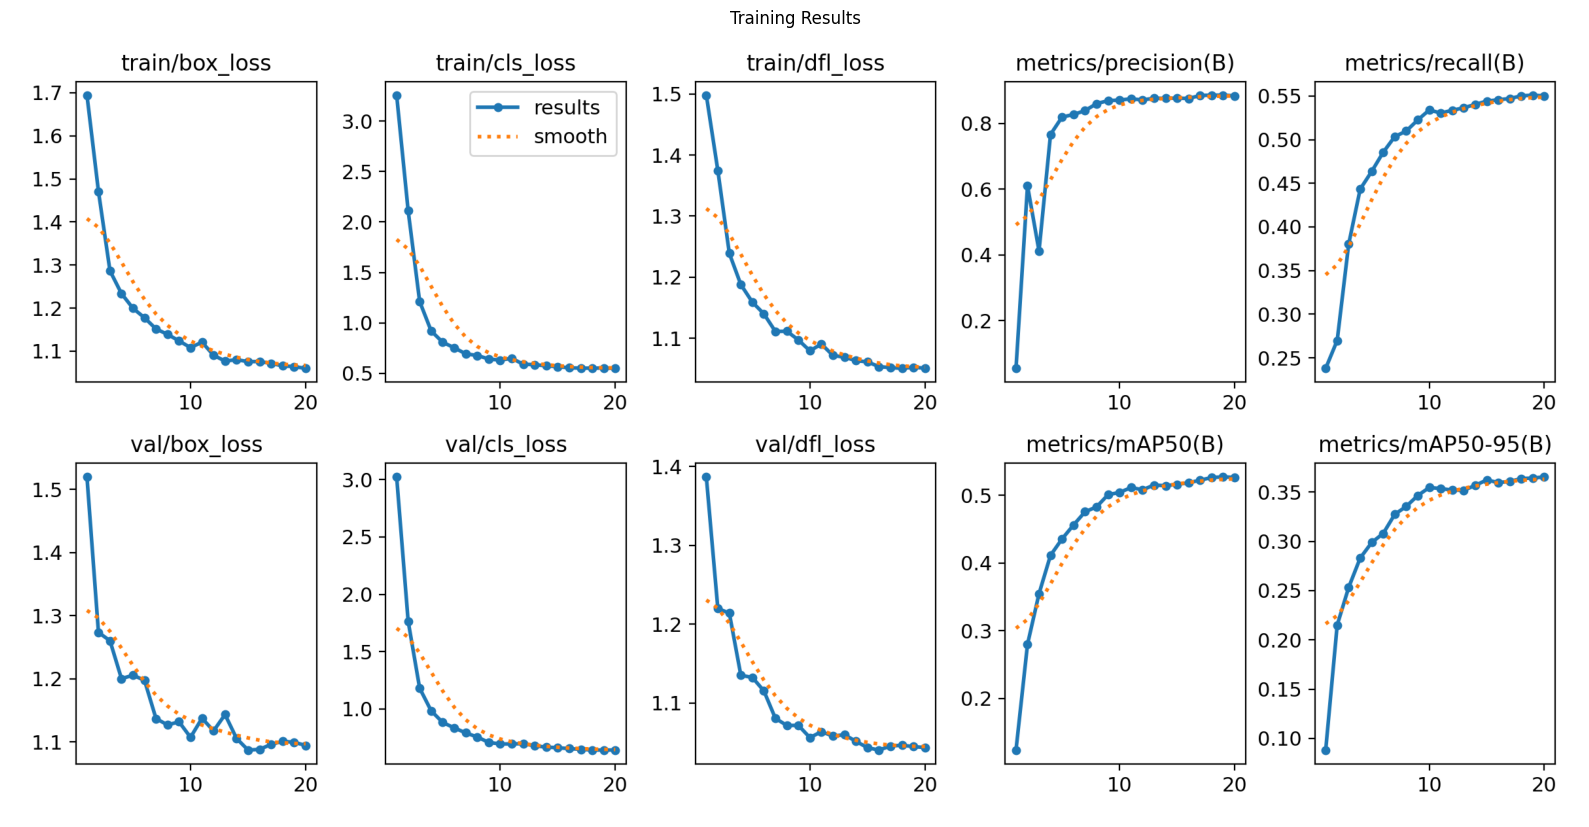

In [29]:
# Display training curves
results_png = RUNS_DIR / f'uml-yolov8{MODEL_SIZE}' / 'results.png'
if results_png.exists():
    img = Image.open(results_png)
    plt.figure(figsize=(16, 10))
    plt.imshow(np.array(img))
    plt.title('Training Results')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("results.png not found")

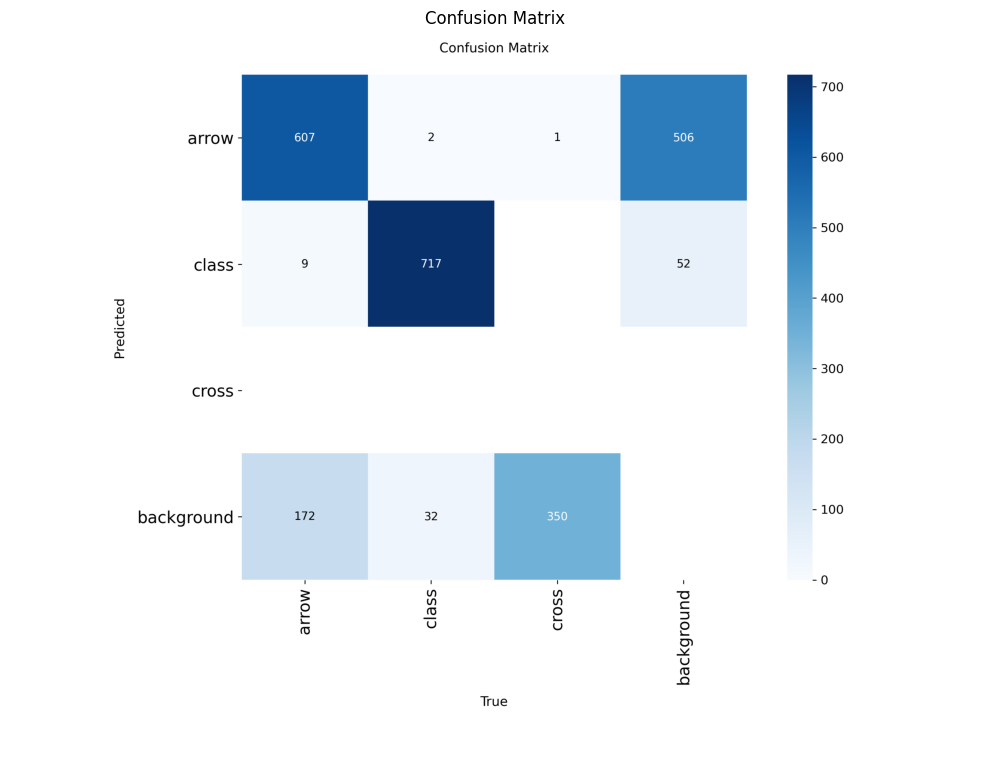

In [21]:
# Display confusion matrix
confusion_png = RUNS_DIR / f'uml-yolov8{MODEL_SIZE}' / 'confusion_matrix.png'
if confusion_png.exists():
    img = Image.open(confusion_png)
    plt.figure(figsize=(10, 8))
    plt.imshow(np.array(img))
    plt.title('Confusion Matrix')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("confusion_matrix.png not found")

In [31]:
# Display PR curve
pr_png = RUNS_DIR / f'uml-yolov8{MODEL_SIZE}' / 'PR_curve.png'
if pr_png.exists():
    img = Image.open(pr_png)
    plt.figure(figsize=(10, 8))
    plt.imshow(np.array(img))
    plt.title('Precision-Recall Curve')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("PR_curve.png not found")

PR_curve.png not found


## 7. Run Inference on Test Images

In [23]:
# Reload the best model for evaluation
best_model_path = RUNS_DIR / f'uml-yolov8{MODEL_SIZE}' / 'weights' / 'best.pt'
best_model = YOLO(str(best_model_path))
print(f"Loaded best model from: {best_model_path}")

Loaded best model from: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool\runs\detect\uml-yolov8m\weights\best.pt


In [24]:
# Get sample test images
test_images_dir = yolo_dir / 'test' / 'images'
test_images = list(test_images_dir.glob('*.jpg'))[:6]

print(f"Running inference on {len(test_images)} test images...")

Running inference on 6 test images...


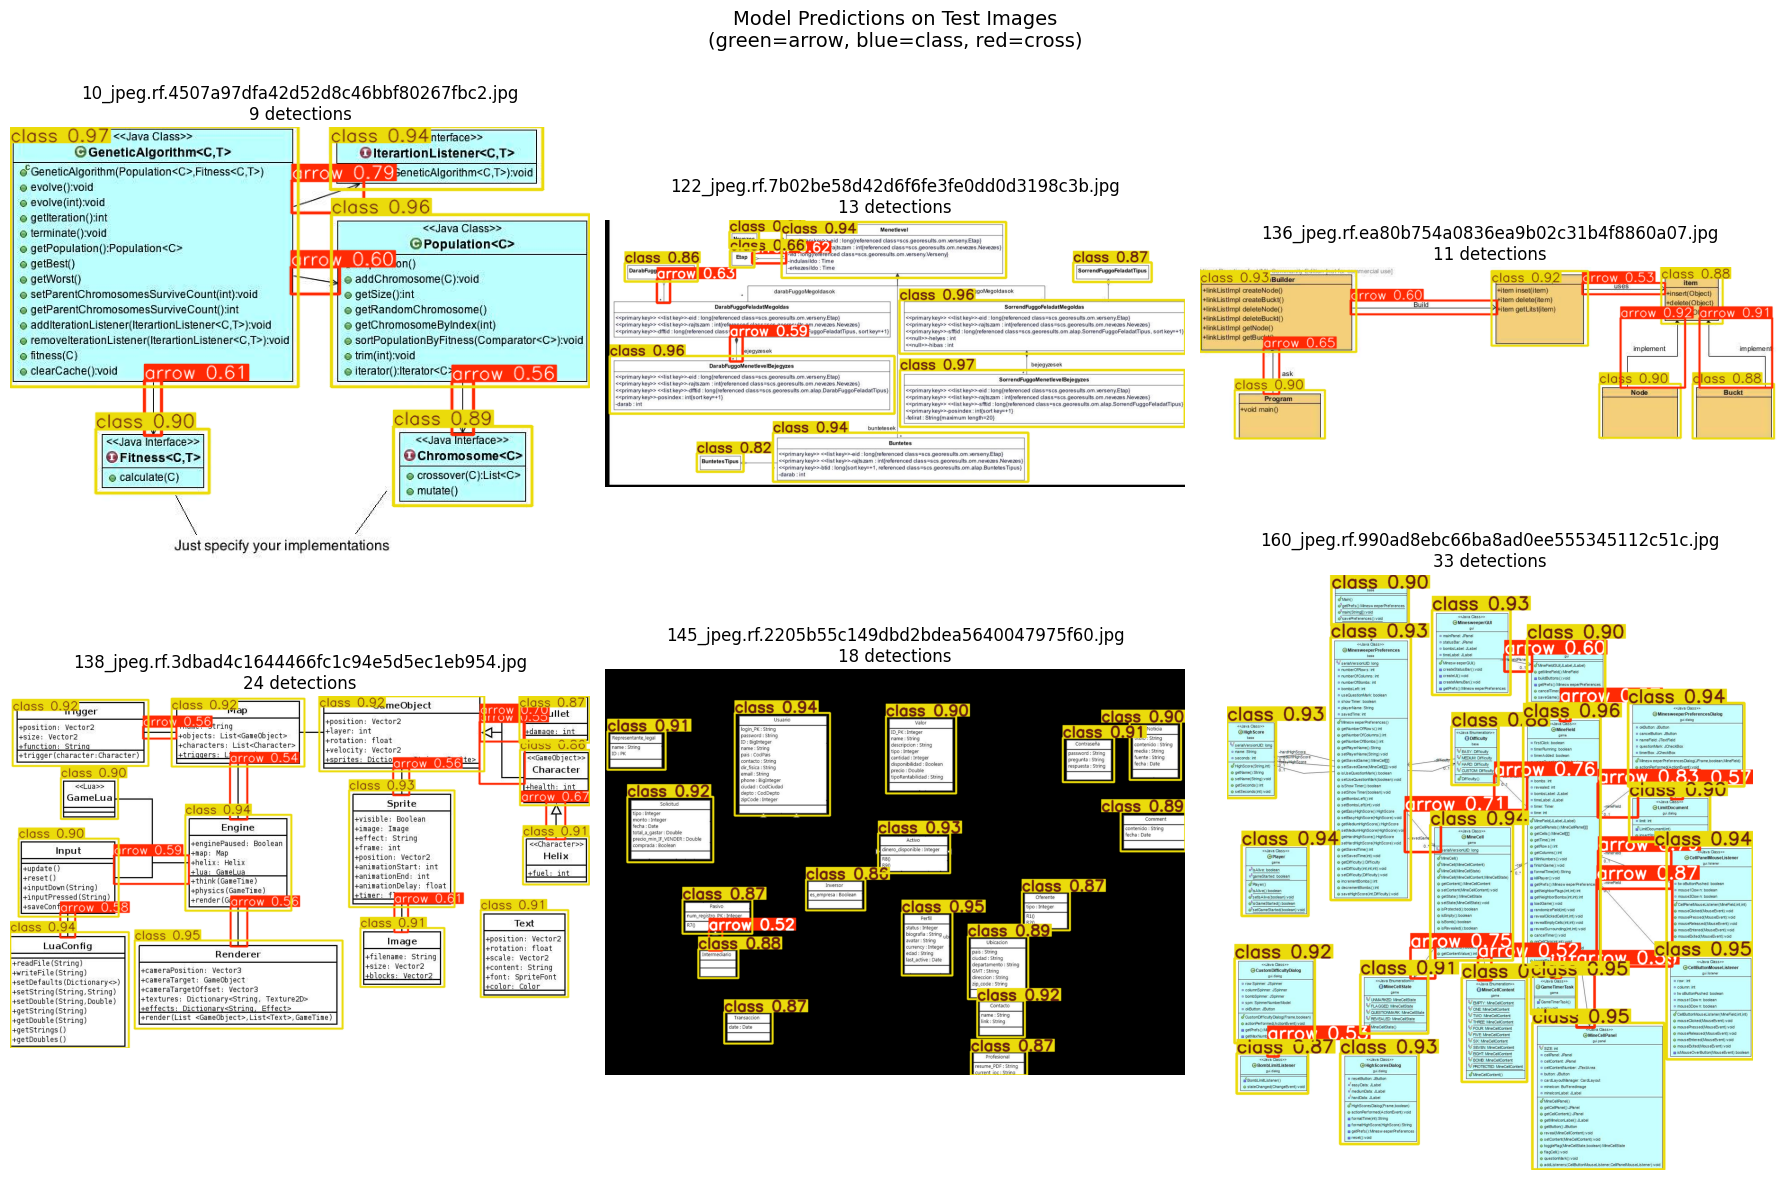

In [25]:
# Run inference and visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(test_images):
    # Run prediction
    results = best_model.predict(
        source=str(img_path),
        conf=0.5,
        iou=0.45,
        device=DEVICE,
        verbose=False
    )
    
    # Get annotated image
    annotated = results[0].plot()
    
    # Display
    axes[idx].imshow(annotated)
    n_detections = len(results[0].boxes)
    axes[idx].set_title(f"{img_path.name}\n{n_detections} detections")
    axes[idx].axis('off')

plt.suptitle("Model Predictions on Test Images\n(green=arrow, blue=class, red=cross)", fontsize=14)
plt.tight_layout()
plt.show()

In [26]:
# Detailed prediction analysis for one image
sample_img = test_images[0]
results = best_model.predict(
    source=str(sample_img),
    conf=0.5,
    device=DEVICE,
    verbose=False
)

print(f"\nDetailed predictions for: {sample_img.name}")
print(f"Total detections: {len(results[0].boxes)}")
print("\nDetections:")

for i, box in enumerate(results[0].boxes):
    cls_id = int(box.cls)
    cls_name = results[0].names[cls_id]
    conf = float(box.conf)
    xyxy = box.xyxy[0].cpu().numpy()
    print(f"  {i+1}. {cls_name} (conf: {conf:.3f}) - bbox: [{xyxy[0]:.0f}, {xyxy[1]:.0f}, {xyxy[2]:.0f}, {xyxy[3]:.0f}]")


Detailed predictions for: 10_jpeg.rf.4507a97dfa42d52d8c46bbf80267fbc2.jpg
Total detections: 9

Detections:
  1. class (conf: 0.971) - bbox: [0, 0, 320, 289]
  2. class (conf: 0.962) - bbox: [357, 99, 645, 289]
  3. class (conf: 0.941) - bbox: [357, 1, 592, 70]
  4. class (conf: 0.901) - bbox: [96, 337, 222, 407]
  5. class (conf: 0.891) - bbox: [426, 333, 580, 421]
  6. arrow (conf: 0.794) - bbox: [313, 60, 394, 97]
  7. arrow (conf: 0.615) - bbox: [149, 283, 169, 344]
  8. arrow (conf: 0.602) - bbox: [313, 156, 366, 187]
  9. arrow (conf: 0.558) - bbox: [492, 283, 516, 342]


## 8. Save and Export Model

In [27]:
# Copy best model to models directory
final_model_path = MODELS_DIR / 'uml_detector_best.pt'
shutil.copy(best_model_path, final_model_path)
print(f"Best model copied to: {final_model_path}")

Best model copied to: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool\models\uml_detector_best.pt


In [ ]:
# Export to ONNX format (optional, for deployment)
# Uncomment to export:
# best_model.export(format='onnx')
# print("Model exported to ONNX format")

In [28]:
# Test loading the saved model
loaded_model = YOLO(str(final_model_path))
print(f"Successfully loaded model from: {final_model_path}")
print(f"Model classes: {loaded_model.names}")

Successfully loaded model from: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool\models\uml_detector_best.pt
Model classes: {0: 'arrow', 1: 'class', 2: 'cross'}


## 9. Summary

### Training Complete!

**Model outputs:**
- Best model: `models/uml_detector_best.pt`
- Training run: `runs/detect/uml-yolov8m/`

**Generated files:**
- `weights/best.pt` - Best model checkpoint
- `weights/last.pt` - Last model checkpoint
- `results.csv` - Epoch-by-epoch metrics
- `confusion_matrix.png` - Class confusion visualization
- `results.png` - Training curves
- `PR_curve.png` - Precision-Recall curve

### Next Steps

1. **OCR Extraction (Notebook 03)**: Extract text from detected class boxes
2. **Knowledge Graph (Notebook 04)**: Build graph from extracted relationships
3. **GraphRAG Query (Notebook 05)**: Enable natural language queries

### Usage

```python
from ultralytics import YOLO

# Load trained model
model = YOLO('models/uml_detector_best.pt')

# Run inference
results = model.predict('path/to/uml_diagram.jpg', conf=0.5)

# Access detections
for box in results[0].boxes:
    cls_name = results[0].names[int(box.cls)]
    confidence = float(box.conf)
    bbox = box.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2]
```